In [448]:
import os
import numpy as np
import pandas as pd
import re
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

# On élargit un peu les fenêtres d'affichage de matplotlib.
plt.rcParams["figure.figsize"] = (9,6)

# On charge notre package.
import satellite as sat
from satellite import Ocli
from netCDF4 import Dataset

In [449]:
%reload_ext autoreload
%autoreload 2

# Première partie - Analyse de l’évolution de la couverture végétale d'une zone

In [450]:
#On génèrela table avec l'ensemble des fichiers + date + nombre de révisions 

rawdir = "C:\\Users\\Cleme\\C0176307"
oc = Ocli(rawdir,'pondi.geojson')
oc.df.head()

,DATE,FILE,REVISION
0,2023-03-20,C:\Users\Cleme\C0176307\FCOVER300_RT0_20230320...,0
1,2023-03-10,C:\Users\Cleme\C0176307\FCOVER300_RT1_20230310...,1
2,2023-01-31,C:\Users\Cleme\C0176307\FCOVER300_RT2_20230131...,2
3,2023-02-10,C:\Users\Cleme\C0176307\FCOVER300_RT2_20230210...,2
4,2023-02-20,C:\Users\Cleme\C0176307\FCOVER300_RT2_20230220...,2


In [451]:
# Nous excluons deux fichiers nc qui ont été corrompus pendant le téléchargement avec filezilla
excl = []
excl.append(oc.df.FILE[14])
excl.append(oc.df.FILE[15])

In [452]:
# Fonction qui étant donné un fichier nz renvoie le taux de couverture moyen
gz = sat.GeoZone('pondi.geojson')
zone = gz[0]
lat0,lon0,lat1,lon1 = zone['bbox']

def CVM(fname):
    if fname in excl:
        return
    with Dataset(fname, 'r') as nc:
        # Cacul des coordonnées utiles.
        lon = nc.variables['lon'][:].data
        lat = nc.variables['lat'][:].data

        # Extraction des données FCOVER.
        bx = np.logical_and(lon0<=lon, lon<=lon1)
        by = np.logical_and(lat0<=lat, lat<=lat1)
        fc = nc.variables['FCOVER'][0,by,bx]

        # On gère le masque par des NaN.
        F = fc.data
        F[fc.mask] = np.nan
    m = np.nanmean(F)
    # print(f"Taux de couverture végétale moyen : {100*m:.1f}%.")
    return m

# Fonction qui étant donné un nc renvoie le RMSE
def RMSE(fname):
    if fname in excl:
        return
    with Dataset(fname, 'r') as nc:
        # Cacul des coordonnées utiles.
        lon = nc.variables['lon'][:].data
        lat = nc.variables['lat'][:].data

        # Extraction des données FCOVER.
        bx = np.logical_and(lon0<=lon, lon<=lon1)
        by = np.logical_and(lat0<=lat, lat<=lat1)
        fc = nc.variables['RMSE'][0,by,bx]

        # On gère le masque par des NaN.
        F = fc.data
        F[fc.mask] = np.nan
    m = np.nanmean(F)
    return m


def PR(fname):
    if fname in excl:
        return
    with Dataset(fname, 'r') as nc:
        # Cacul des coordonnées utiles.
        lon = nc.variables['lon'][:].data
        lat = nc.variables['lat'][:].data

        # Extraction des données FCOVER.
        bx = np.logical_and(lon0<=lon, lon<=lon1)
        by = np.logical_and(lat0<=lat, lat<=lat1)
        fc = nc.variables['RMSE'][0,by,bx]

        # On gère le masque par des NaN.
        F = fc.data
        F[fc.mask] = np.nan
    m = 1 - np.count_nonzero(np.isnan(F))/np.size(F, axis=None)
    return m

In [453]:
# On génère les nouvelles colonnes en utilisant les fonctions précédemment crées

oc.df['FCOVER'] = oc.df['FILE'].apply(CVM)
oc.df['RMSE'] = oc.df['FILE'].apply(RMSE)
oc.df['PR'] = oc.df['FILE'].apply(PR)
oc.df = oc.df.drop(index=14, axis=0)
oc.df = oc.df.drop(index=15, axis=0)

oc.df.set_index(pd.to_datetime(oc.df['DATE']), inplace=True)
oc.df.drop(columns=['DATE'], inplace=True)
oc.df.sort_index(inplace=True)
oc.df.head()

,FILE,REVISION,FCOVER,RMSE,PR
DATE,,,,,
2022-03-31,C:\Users\Cleme\C0176307\FCOVER300_RT6_20220331...,6,0.361884,0.095540,0.894614
2022-04-10,C:\Users\Cleme\C0176307\FCOVER300_RT6_20220410...,6,0.393652,0.094347,0.979474
2022-04-20,C:\Users\Cleme\C0176307\FCOVER300_RT6_20220420...,6,0.428392,0.091286,0.982918
2022-04-30,C:\Users\Cleme\C0176307\FCOVER300_RT6_20220430...,6,0.449295,0.084804,0.990495
2022-05-10,C:\Users\Cleme\C0176307\FCOVER300_RT6_20220510...,6,0.461958,0.082866,0.988428


Text(0, 0.5, 'FCOVER')

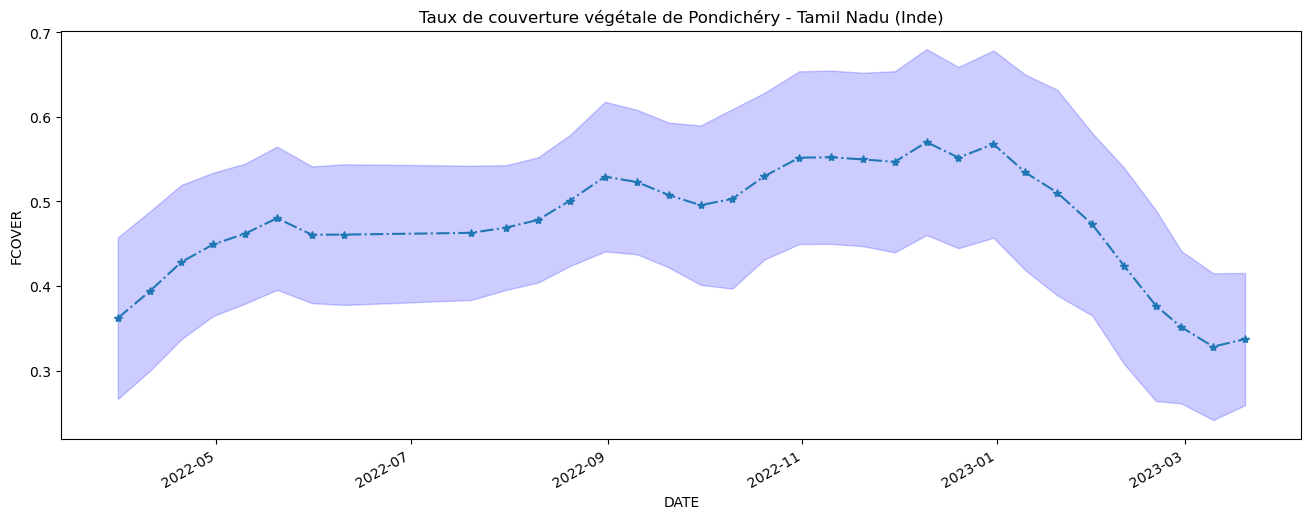

In [454]:
df = oc.df[['FCOVER', 'RMSE']]
y = df['FCOVER']
e = df['RMSE']

fig,ax = plt.subplots(figsize= (16, 6))
x = df.index
y.plot(style='*-.')
ax.fill_between(x, y-e, y+e, color='b', alpha=0.2)
plt.title('Taux de couverture végétale de Pondichéry - Tamil Nadu (Inde)')
plt.ylabel('FCOVER')

In [456]:
import statsmodels.api as sm
from statsmodels.tsa.deterministic import CalendarFourier

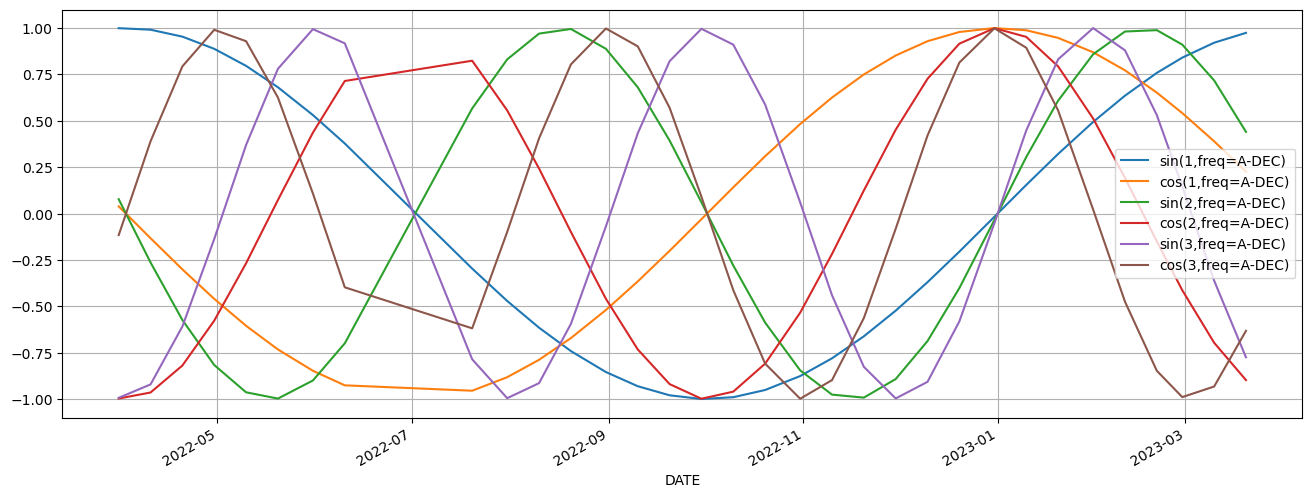

In [457]:
# Création d'un signal multivarié d'harmoniques de l'année.

fourier_gen = CalendarFourier('Y', order=3)
fg = fourier_gen.in_sample(df.index)

fg.plot(figsize=(16, 6))
plt.grid()

In [458]:
# On redéfinit y car on a changé l'index entre temps
y = oc.df['FCOVER']
fg['constant']= 1
fg['days'] = (fg.index - fg.index[0]).total_seconds()/(24*3600)

In [459]:
# Regression linéaire de y sur les harmoniques, la constante et la tendance.
mod = sm.OLS(y, fg)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 FCOVER   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     126.0
Date:                Wed, 26 Apr 2023   Prob (F-statistic):           6.88e-18
Time:                        19:04:44   Log-Likelihood:                 101.06
No. Observations:                  33   AIC:                            -186.1
Df Residuals:                      25   BIC:                            -174.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
sin(1,freq=A-DEC)    -0.0697      0.00

In [460]:
y = df['FCOVER']
e = df['RMSE']

In [461]:
r = pd.Series(res.predict(), index=df.index)

Text(0, 0.5, 'm')

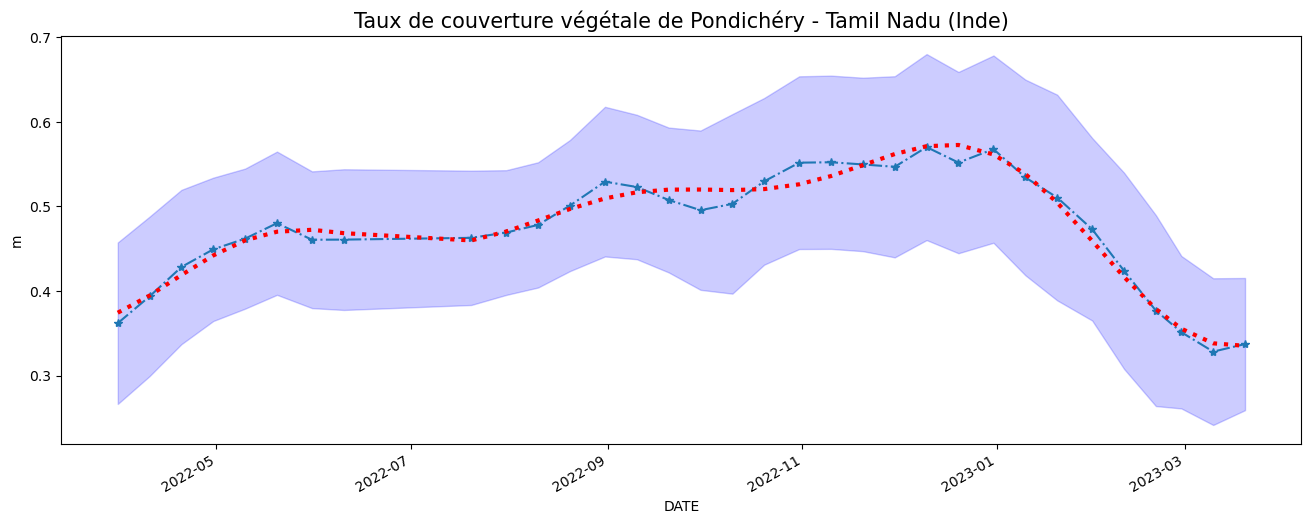

In [462]:
fig,ax = plt.subplots(figsize=(16, 6))
y.plot(style='*-.')
ax.fill_between(x, y-e, y+e, color='b', alpha=0.2)
r.plot(style=':', color='r', linewidth=3)
plt.title("Taux de couverture végétale de Pondichéry - Tamil Nadu (Inde)", fontsize=15)
plt.ylabel('m')